In [40]:
import numpy as np
import os
import torch
import pickle
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.express as px
import plotly as py
import pandas as pd
from chart_studio.plotly import plot, iplot

# from plotly.offline import init_notebook_mode, iplot
from tqdm import tqdm_notebook

from scvi.dataset import (
    PowSimSynthetic,
    LatentLogPoissonDataset,
    SignedGamma,
    GeneExpressionDataset,
)
from scvi.models import VAE, IAVAE
from scvi.inference import UnsupervisedTrainer
from scvi.utils import (
    demultiply,
    make_dir_if_necessary,
    predict_de_genes,
    save_fig,
    load_pickle,
    save_pickle,
    has_lower_mean,
    softmax,
    compute_hdi
)
from scvi_utils import (
    estimate_de_proba,
    estimate_lfc_density,
    estimate_lfc_mean,
    multi_train_estimates,
    train_model
)
from R_interop import all_predictions, all_de_predictions


N_EPOCHS = 200
DELTA = 0.5
SIZES = [5, 10, 20, 30, 50, 100]
SIZE = 100
N_SIZES = len(SIZES)
DO_CLOUD = True
Q0 = 5e-2
N_TRAININGS = 5
N_PICKS = 10
n_genes = 1000
FREQUENCY = 1
np.random.seed(42)
torch.manual_seed(42)

PATH_TO_SCRIPTS = "/home/ubuntu/conquer_comparison/scripts"
DIR_PATH = "lfc_estimates/lognormal2"
DF_PATH = "/home/ubuntu/scVI/scvi/dataset/kolodziejczk_param.csv"
make_dir_if_necessary(DIR_PATH)

# Generate Dataset

## Constructing mu and sigma

In [ ]:
selected = pd.read_csv(DF_PATH).sample(n_genes)
means = selected["means"].values

means[means >= 1000] = 1000
go.Figure([go.Histogram(x=means)]).show()

lfc_sampler = SignedGamma(dim=2, proba_pos=0.5)
lfcs = lfc_sampler.sample(n_genes).numpy()
non_de_genes = np.random.choice(n_genes, size=300)
lfcs[non_de_genes, :] = 0.0
go.Figure([go.Histogram(x=lfcs[:, 0])]).show()

log2_mu0 = lfcs[:, 0] + np.log2(means)
log2_mu1 = lfcs[:, 1] + np.log2(means)

loge_mu0 = log2_mu0 / np.log2(np.e)
loge_mu1 = log2_mu1 / np.log2(np.e)

In [4]:
a = (2.0 * np.random.random(size=(n_genes, 1)) - 1).astype(float)
sigma = 2.0 * a.dot(a.T) + 0.5 * (
    1.0 + 0.5 * (2.0 * np.random.random(n_genes) - 1.0)
) * np.eye(n_genes)

sigma0 = 0.1 * sigma
sigma1 = sigma0

# sigma1 = sigma

# u, s, vh = np.linalg.svd(sigma)
# perturbations = s.min() + (s.max() - s.min()) * np.random.random(len(s))
# sigma1 = u @ (np.diag(perturbations)) @ vh

In [5]:
h0 = torch.distributions.MultivariateNormal(
    loc=torch.tensor(loge_mu0), covariance_matrix=torch.tensor(sigma0)
).sample((5000,))
h1 = torch.distributions.MultivariateNormal(
    loc=torch.tensor(loge_mu1), covariance_matrix=torch.tensor(sigma1)
).sample((5000,))

h = torch.cat([h0, h1])

In [ ]:
x_obs = torch.distributions.Poisson(rate=h.exp()).sample()
# is_zi = np.random.random(x_obs.shape) >= 0.9
is_zi = (np.random.random(x_obs.shape) <= np.exp(-0.5 * x_obs.numpy())) | (
    np.random.random(x_obs.shape) <= 0.4
)
print(is_zi.mean())
x_obs[is_zi] = 0.0
labels = torch.zeros((10000, 1))
labels[5000:] = 1

not_null_cell = x_obs.sum(1) != 0
x_obs = x_obs[not_null_cell]
labels = labels[not_null_cell]

trace1 = go.Histogram(x=x_obs.mean(0))
fig = go.Figure(data=[trace1])
fig.show()

In [7]:
lfcs0 = lfcs.copy()

In [8]:
# assert False
dataset_path = os.path.join(DIR_PATH, "dataset.pickle")
if not os.path.exists(dataset_path):
    dataset = GeneExpressionDataset()
    dataset.populate_from_data(X=x_obs.numpy(), labels=labels.numpy())
    dataset.lfc = lfcs
    save_pickle(data=dataset, filename=dataset_path)
else:
    dataset = load_pickle(dataset_path)
    lfcs = dataset.lfc

In [9]:
lfcs == lfcs0

array([[ True,  True],
       [ True,  True],
       [ True,  True],
       ...,
       [ True,  True],
       [ True,  True],
       [ True,  True]])

In [ ]:
h0_bis, h1_bis = demultiply(h0, h1, factor=6)
lfc_orig = h0_bis.exp().log2() - h1_bis.exp().log2()
lfc_gt = lfc_orig.mean(0)
lfc_gt = lfc_gt.numpy()

# is_significant_de = (np.abs(lfc_orig) >= DELTA).numpy().mean(0) >= 0.5
is_significant_de = np.abs(lfcs[:, 0] - lfcs[:, 1]) >= DELTA
n_genes = dataset.nb_genes
trace1 = go.Histogram(x=lfcs[:, 1] - lfcs[:, 0])
fig = go.Figure(data=[trace1])
# save_fig(fig, filename="powsimR_properties", do_cloud=DO_CLOUD)
fig.show()

In [11]:
n_examples = len(dataset)
TEST_INDICES = np.random.permutation(n_examples)[:2000]

x_test, y_test = dataset.X[TEST_INDICES, :], dataset.labels[TEST_INDICES, :].squeeze()
data_path = os.path.join(DIR_PATH, "data.npy")
labels_path = os.path.join(DIR_PATH, "labels.npy")
means_path = os.path.join(DIR_PATH, "means.npy")

np.save(data_path, x_test.squeeze().astype(int))
np.save(means_path, h[TEST_INDICES].exp())
np.savetxt(labels_path, y_test.squeeze())

# Compute scVI-based results

In [12]:
mdl_params = dict(
    iaf=dict(n_hidden=128, n_layers=1, do_h=True, n_latent=10, t=4, dropout_rate=0.2),
    mf=dict(n_hidden=128, n_layers=1, n_latent=10, dropout_rate=0.2),
)

train_params = dict(
    iaf=dict(
        ratio_loss=True,
        test_indices=TEST_INDICES,
    ),
    mf=dict(
        ratio_loss=True,
        test_indices=TEST_INDICES,
    ),
)

train_fn_params = dict(
    iaf=dict(n_epochs=N_EPOCHS, lr=1e-2),
    mf=dict(n_epochs=N_EPOCHS, lr=1e-2),
)

In [13]:
res_mf = multi_train_estimates(
    filename=os.path.join(DIR_PATH, "res_mf_final1_high_lr_epochs.pickle"),
    mdl_class=VAE,
    dataset=dataset,
    mdl_params=mdl_params["mf"],
    train_params=train_params["mf"],
    train_fn_params=train_fn_params["mf"],
    sizes=SIZES,
    n_trainings=N_TRAININGS,
    n_picks=N_PICKS,
    n_samples=500,
    label_a=0,
    normalized_means=h.exp(),
    label_b=1,
).assign(algorithm="MF")


res_iaf = multi_train_estimates(
    filename=os.path.join(DIR_PATH, "res_iaf_final1_high_lr_epochs.pickle"),
    mdl_class=IAVAE,
    dataset=dataset,
    mdl_params=mdl_params["iaf"],
    train_params=train_params["iaf"],
    train_fn_params=train_fn_params["iaf"],
    sizes=SIZES,
    n_trainings=N_TRAININGS,
    n_picks=N_PICKS,
    n_samples=500,
    normalized_means=h.exp(),
    label_a=0,
    label_b=1,
).assign(algorithm="IAF")

# Compute competitors scores

In [14]:
other_predictions = all_predictions(
    filename=os.path.join(DIR_PATH, "other_predictions_double_check.pickle"),
    n_genes=n_genes,
    n_picks=N_PICKS,
    sizes=SIZES,
    data_path=data_path,
    labels_path=labels_path,
    normalized_means=means_path,
    delta=DELTA,
    path_to_scripts=PATH_TO_SCRIPTS,
)

other_predictions = all_de_predictions(
    other_predictions, significance_level=Q0, delta=DELTA
)

Check sign of LFC 

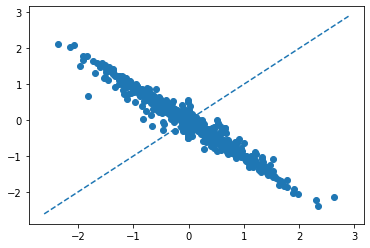

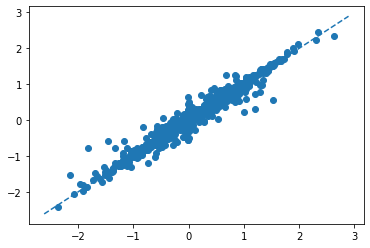

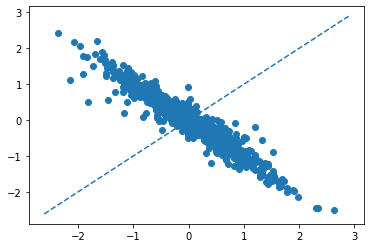

In [15]:
from scvi.utils import plot_identity

# lfc_gt = -(lfcs[:, 1] - lfcs[:, 0])
# lfc_gt = - (h[:, 1] - lfcs0[:, 0])
plt.scatter(lfc_gt, other_predictions["edger"]["lfc"][-1, -1, :])
plot_identity()
plt.show()

plt.scatter(lfc_gt, other_predictions["deseq2"]["lfc"][-1, -1, :])
plot_identity()
plt.show()


plt.scatter(lfc_gt, other_predictions["mast"]["lfc"][-1, -1, :])
plot_identity()
plt.show()

In [16]:
other_predictions["edger"]["lfc"] = -other_predictions["edger"]["lfc"]
other_predictions["mast"]["lfc"] = -other_predictions["mast"]["lfc"]

# Experiments

In [17]:
def algos_comparison(my_df, key1, other_keys, key_values="error"):
    vals_key1 = my_df.loc[my_df["algorithm"] == key1, key_values].values
    algo1_is_better = True
    for key2 in other_keys:
        vals_other = my_df.loc[my_df["algorithm"] == key2, key_values].values
        try:
            key1_better = has_lower_mean(vals_key1, vals_other)
        except ValueError:
            key1_better = False
            break
        if not key1_better:
            algo1_is_better = False
            break
    return key1_better

In [18]:
def train_model(
    mdl_class, dataset, mdl_params: dict, train_params: dict, train_fn_params: dict
):
    """

    :param mdl_class: Class of algorithm
    :param dataset: Dataset
    :param mdl_params:
    :param train_params:
    :param train_fn_params:
    :return:
    """
    my_vae = mdl_class(dataset.nb_genes, n_batch=dataset.n_batches, **mdl_params)
    my_trainer = UnsupervisedTrainer(my_vae, dataset, **train_params)
    print(my_trainer.test_set.data_loader.sampler.indices)
    my_trainer.train(**train_fn_params)
    print(my_trainer.train_losses)
    return my_vae, my_trainer

## PR Curves

#### PR Curve

In [19]:
selected_training = 2

preds_md = res_mf.loc[
    lambda x: (x.experiment == 2)
    & (x.training == selected_training)
    & (x.sample_size == 100)
].sort_values("gene")["de_proba"]

preds_iaf = res_iaf.loc[
    lambda x: (x.experiment == 2)
    & (x.training == selected_training)
    & (x.sample_size == 100)
].sort_values("gene")["de_proba"]


In [20]:
other_predictions["deseq2"]["pval"].shape

(6, 10, 1000)

In [21]:
from sklearn.metrics import precision_recall_curve

preds_deseq2 = 1.0 - other_predictions["deseq2"]["pval"][-1, 0, :] + 1e-10*np.random.randn(n_genes)
preds_edger = 1.0 - other_predictions["edger"]["pval"][-1, 0, :] #+ 1e-10*np.random.randn(n_genes)
preds_mast = 1.0 - other_predictions["mast"]["pval"][-1, 0, :] #+ 1e-10*np.random.randn(n_genes)

In [22]:
CONTROL_ALPHA = False
from scipy.stats import mannwhitneyu


def fdr_fnr(my_df, control_alpha=True):
    my_df = my_df.sort_values("gene")
    assert len(my_df) == n_genes
    if control_alpha:
        is_pred_de = predict_de_genes(my_df.de_proba.values, desired_fdr=Q0)
        alpha = my_df.de_proba.values[is_pred_de].min()
    else:
        is_pred_de = my_df.de_proba.values >= 0.5
        alpha = 0.5
    true_fdr = ((1.0 - is_significant_de) * is_pred_de).sum() / is_pred_de.sum()
    n_positives = is_significant_de.sum()
    true_fnr = (is_significant_de * (1.0 - is_pred_de)).sum() / n_positives
    return pd.Series(dict(fdr=true_fdr, fnr=true_fnr, alpha=alpha))


fdr_fnr_mf = (
    res_mf.groupby(["experiment", "training", "sample_size"])
    .apply(fdr_fnr, control_alpha=CONTROL_ALPHA)
    .reset_index()
    .assign(algorithm="MF")
)
fdr_fnr_iaf = (
    res_iaf.groupby(["experiment", "training", "sample_size"])
    .apply(fdr_fnr, control_alpha=CONTROL_ALPHA)
    .reset_index()
    .assign(algorithm="IAF")
)


df = pd.concat(
    [
        fdr_fnr_mf,
        fdr_fnr_iaf,
    ],
    ignore_index=True,
)

df.loc[:, "recall"] = 1.0 - df.loc[:, "fnr"]
recall_ranges = df.loc[lambda x: x.sample_size == 100].groupby(["algorithm"])["recall"]

min_recalls = recall_ranges.mean() - 2.0*recall_ranges.std() 
max_recalls = recall_ranges.mean() + 2.0*recall_ranges.std() 
display(min_recalls, max_recalls)

algorithm
IAF    0.949701
MF     0.942038
Name: recall, dtype: float64

algorithm
IAF    0.982931
MF     0.979180
Name: recall, dtype: float64

In [23]:
stat, pval = mannwhitneyu(
    df.loc[lambda x: x.algorithm=="IAF", "recall"],
    df.loc[lambda x: x.algorithm=="MF", "recall"],
    alternative="greater"
)

print("Recall IAF Better : ", stat, pval)

Recall IAF Better :  56164.5 6.67024115426289e-08


In [24]:
df.loc[:, "precision"] = 1.0 - df.loc[:, "fdr"]
precision_ranges = df.loc[lambda x: x.sample_size == 100].groupby(["algorithm"])["precision"]

min_precisions = precision_ranges.mean() - 2.0*precision_ranges.std() 
max_precisions = precision_ranges.mean() + 2.0*precision_ranges.std()
max_precisions[max_precisions>=1.0] = 1.0
display(min_precisions, max_precisions)

algorithm
IAF    0.956786
MF     0.925704
Name: precision, dtype: float64

algorithm
IAF    0.997577
MF     1.000000
Name: precision, dtype: float64

In [25]:
stat, pval = mannwhitneyu(
    df.loc[lambda x: x.algorithm=="IAF", "precision"],
    df.loc[lambda x: x.algorithm=="MF", "precision"],
    alternative="greater"
)

print("Precision IAF better : ", stat, pval)

Precision IAF better :  50875.0 0.002828438101704957


In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score
opacity = 0.6

def plot_pr(fig, preds, y_true, name):
    average_precision = average_precision_score(y_true, preds)
    preds[np.isnan(preds)] = np.min(preds[~np.isnan(preds)])
    precs, recs, _ = precision_recall_curve(y_true=y_true, probas_pred=preds)
    fig.add_trace(
        go.Scatter(
            x=recs, y=precs, name=name + "@AP: {0:0.2f}".format(average_precision)
        )
    )
    return


layout = go.Layout(
    title="Precision Recall Curves",
    xaxis=dict(title="Recall"),
    yaxis=dict(title="Precision"),
    width=800,
    height=600,
)

fig = go.Figure(layout=layout)
plot_pr(fig=fig, preds=preds_md, y_true=is_significant_de, name="MF")
plot_pr(fig=fig, preds=preds_iaf, y_true=is_significant_de, name="IAF")
plot_pr(fig=fig, preds=preds_deseq2, y_true=is_significant_de, name="DESeq2")
plot_pr(fig=fig, preds=preds_edger, y_true=is_significant_de, name="EdgeR")
plot_pr(fig=fig, preds=preds_mast, y_true=is_significant_de, name="MAST")

layouts = [
    go.layout.Shape(
        type="rect",
        x0=min_recalls.MF,
        y0=min_precisions.MF,
        x1=max_recalls.MF,
        y1=max_precisions.MF,
        line=dict(color="blue", width=2),
        fillcolor="blue",
        opacity=opacity
    ),
    go.layout.Shape(
        type="rect",
        x0=min_recalls.IAF,
        y0=min_precisions.IAF,
        x1=max_recalls.IAF,
        y1=max_precisions.IAF,
        line=dict(color="red", width=2),
        fillcolor="red",
        opacity=opacity
    ),
]

fig.update_layout(shapes=layouts)
fig.update_xaxes(range=[0.5, 1.01])
fig.update_yaxes(range=[0.5, 1.01])
fig.show()

#### MAP

In [ ]:
def do_ap(my_df):
    my_df = my_df.sort_values("gene")
    average_precision = average_precision_score(is_significant_de, my_df.de_proba)
    return pd.Series(dict(AP=average_precision))


ap_mf = (
    res_mf.groupby(["experiment", "training", "sample_size"])
    .apply(do_ap)
    .reset_index()
    .assign(algorithm="MF")
)
ap_iaf = (
    res_iaf.groupby(["experiment", "training", "sample_size"])
    .apply(do_ap)
    .reset_index()
    .assign(algorithm="IAF")
)


all_ap = pd.concat(
    [
        ap_mf,
        ap_iaf,

    ],
    ignore_index=True,
)

px.box(all_ap, x="sample_size", y="AP", color="algorithm")

## Diagonal Curve

In [28]:
selected_training = 0
subsample_genes = np.sort(np.random.permutation(n_genes)[:120])

lfcs_mf = (
    res_mf.loc[
        lambda x: (x.experiment == 0)
        & (x.training == selected_training)
        & (x.sample_size == 100)
        & (x.gene.isin(subsample_genes))
    ]
    .sort_values("gene")[
        ["lfc_mean", "hdi99_low", "hdi99_high", "hdi64_low", "hdi64_high", "algorithm"]
    ]
    .assign(
        err_minus=lambda x: x.lfc_mean - x.hdi99_low,
        err_pos=lambda x: x.hdi99_high - x.lfc_mean,
        lfc_gt=lfc_gt[subsample_genes],
    )
)

lfcs_ia = (
    res_iaf.loc[
        lambda x: (x.experiment == 0)
        & (x.training == selected_training)
        & (x.sample_size == 100)
        & (x.gene.isin(subsample_genes))
    ]
    .sort_values("gene")[
        ["lfc_mean", "hdi99_low", "hdi99_high", "hdi64_low", "hdi64_high", "algorithm"]
    ]
    .assign(
        err_minus=lambda x: x.lfc_mean - x.hdi99_low,
        err_pos=lambda x: x.hdi99_high - x.lfc_mean,
        lfc_gt=lfc_gt[subsample_genes],
    )
)

all_lfcs = pd.concat([lfcs_mf, lfcs_ia], ignore_index=True)

In [ ]:
fig = px.scatter(
    all_lfcs,
    x="lfc_gt",
    y="lfc_mean",
    color="algorithm",
    error_y="err_pos",
    error_y_minus="err_minus",
)

fig.add_trace(
    go.Scatter(
        x=[-3, 3],
        y=[-3, 3],
        mode="lines",
        line=dict(color="black", width=4, dash="dash"),
        showlegend=False,
    )
)

fig.show()


## Study of LFC errors

In [30]:
def compute_l2_err(diff):
    res = 0.5 * (diff ** 2) ** (0.5)
    res = np.nanmean(res, axis=-1)
    return res


def l2_err_competitor(vals: np.ndarray, other: np.ndarray = None):
    vals[np.isnan(vals)] = 0.0
    if other is None:
        diff = vals
    else:
        diff = vals - other
    res = compute_l2_err(diff)
    assert res.shape == (N_SIZES, N_PICKS)
    data = []
    for (size_ix, size) in enumerate(SIZES):
        for pick in range(N_PICKS):
            data.append(
                dict(
                    experiment=pick,
                    training=0,
                    sample_size=size,
                    error=res[size_ix, pick],
                )
            )
    return pd.DataFrame(data)


lfcs_errs_deseq2 = l2_err_competitor(
    other_predictions["deseq2"]["lfc"], other=lfc_gt
).assign(algorithm="DESeq2")
lfcs_errs_edger = l2_err_competitor(
    other_predictions["edger"]["lfc"], other=lfc_gt
).assign(algorithm="EdgeR")
lfcs_errs_mast = l2_err_competitor(
    other_predictions["mast"]["lfc"], other=lfc_gt
).assign(algorithm="MAST")

In [ ]:
def pd_l2_err(my_df):
    diff = my_df.sort_values("gene")["lfc_mean"] - lfc_gt
    error = 0.5 * (diff ** 2) ** (0.5)
    error = np.nanmean(error)
    return pd.Series(dict(error=error))


lfcs_errs_mf = (
    res_mf.groupby(["experiment", "sample_size", "training", "algorithm"])
    .apply(pd_l2_err)
    .reset_index()
)

lfcs_errs_iaf = (
    res_iaf.groupby(["experiment", "sample_size", "training", "algorithm"])
    .apply(pd_l2_err)
    .reset_index()
    .assign(algorithm="IAF")
)

all_errs = pd.concat(
    [lfcs_errs_mf, lfcs_errs_iaf, lfcs_errs_deseq2, lfcs_errs_edger, lfcs_errs_mast],
    ignore_index=True,
)

px.box(all_errs, x="sample_size", y="error", color="algorithm")

### Tables

In [32]:
def algos_comparison(my_df, key1, other_keys):
    vals_key1 = my_df.loc[my_df["algorithm"] == key1, "error"].values
    algo1_is_better = True
    for key2 in other_keys:
        vals_other = my_df.loc[my_df["algorithm"] == key2, "error"].values
        key1_better = has_lower_mean(vals_key1, vals_other)
        if not key1_better:
            algo1_is_better = False
            break
    return key1_better


gped = all_errs.groupby("sample_size")
mf_or_iaf_better = gped.apply(
    algos_comparison, key1="MF", other_keys=["DESeq2", "EdgeR", "MAST"]
) & gped.apply(algos_comparison, key1="IAF", other_keys=["DESeq2", "EdgeR", "MAST"])
mf_better = gped.apply(
    algos_comparison, key1="MF", other_keys=["IAF", "DESeq2", "EdgeR", "MAST"]
)
iaf_better = gped.apply(
    algos_comparison, key1="IAF", other_keys=["MF", "DESeq2", "EdgeR", "MAST"]
)

In [33]:
res_table = (
    all_errs.groupby(["sample_size", "algorithm"])
    .error.agg(dict(err_mean="mean", err_std="std"))
    .reset_index()
    .assign(
        displayed=lambda x: x.apply(lambda y: "{:.3f}".format(y.err_mean), axis=1),
        is_better=False,
        one_of_best=False,
    )
)
res_table.loc[res_table["algorithm"] == "MF", "is_better"] = mf_better.values
res_table.loc[res_table["algorithm"] == "IAF", "is_better"] = iaf_better.values
res_table.loc[res_table["algorithm"] == "IAF", "one_of_best"] = mf_or_iaf_better.values
res_table.loc[res_table["algorithm"] == "MF", "one_of_best"] = mf_or_iaf_better.values


res_table.loc[lambda x: x.one_of_best, "displayed"] = (
    res_table.loc[lambda x: x.one_of_best, "displayed"] + "^*"
)
res_table.loc[lambda x: x.is_better, "displayed"] = res_table.loc[
    lambda x: x.is_better, "displayed"
].apply(lambda x: "\mathbf{{ {} }}".format(x))

res_table.loc[:, "displayed"] = res_table.loc[:, "displayed"].apply(
    lambda x: "$ {} $".format(x)
)

/home/ubuntu/anaconda3/envs/scvi/lib/python3.7/site-packages/ipykernel/__main__.py:3: FutureWarning:

using a dict on a Series for aggregation
is deprecated and will be removed in a future version



In [34]:
res_table.pivot(index="algorithm", columns="sample_size", values="displayed").loc[
    ["DESeq2", "EdgeR", "MAST", "MF", "IAF"], [10, 50, 100]
]

sample_size,10,50,100
algorithm,,,
DESeq2,$ 0.151 $,$ 0.069 $,$ 0.053 $
EdgeR,$ 0.170 $,$ 0.072 $,$ 0.052 $
MAST,$ 0.156 $,$ 0.075 $,$ 0.063 $
MF,$ 0.029^* $,$ 0.022^* $,$ 0.019^* $
IAF,$ \mathbf{ 0.025^* } $,$ \mathbf{ 0.017^* } $,$ \mathbf{ 0.016^* } $


In [35]:
print(
    res_table.pivot(index="algorithm", columns="sample_size", values="displayed")
    .loc[["DESeq2", "EdgeR", "MAST", "MF", "IAF"], [5, 20, 100]]
    .to_latex(escape=False)
)

\begin{tabular}{llll}
\toprule
sample_size &          5   &          20  &                     100 \\
algorithm &              &              &                         \\
\midrule
DESeq2    &    $ 0.224 $ &    $ 0.122 $ &               $ 0.053 $ \\
EdgeR     &    $ 0.233 $ &    $ 0.122 $ &               $ 0.052 $ \\
MAST      &    $ 0.231 $ &    $ 0.120 $ &               $ 0.063 $ \\
MF        &  $ 0.032^* $ &  $ 0.025^* $ &             $ 0.019^* $ \\
IAF       &  $ 0.034^* $ &  $ 0.022^* $ &  $ \mathbf{ 0.016^* } $ \\
\bottomrule
\end{tabular}



## Coverage, Local Diagonal curves

In [ ]:
def train_or_load(filepath, my_mdl_class, my_mdl_params, my_train_params, my_train_fn_params):
    if os.path.exists(filepath):
        tup = load_pickle(filepath)
    else:
        tup = train_model(
            mdl_class=my_mdl_class,
            dataset=dataset,
            mdl_params=my_mdl_params,
            train_params=my_train_params,
            train_fn_params=my_train_fn_params,
        )
        save_pickle(tup, filepath)
    return tup


for i in range(5):
    mdl_iaf, trainer_iaf = train_or_load(
        os.path.join(DIR_PATH, "iaf_mdl_{}final1.pickle".format(i)),
        IAVAE,
        mdl_params["iaf"],
        train_params["iaf"],
        train_fn_params["iaf"],
    )

    mdl_mf, trainer_mf = train_or_load(
        os.path.join(DIR_PATH, "mf_mdl_{}final1.pickle".format(i)),
        VAE,
        mdl_params["mf"],
        train_params["mf"],
        train_fn_params["mf"],
    )

mdl_iaf.cuda()
mdl_mf.cuda()
print()

/home/ubuntu/scVI/scvi/models/iavae.py:56: UserWarning:

EXPERIMENTAL: Posterior functionalities may not be working

INFO:scvi.models.iaf_encoder:Using Hidden State
INFO:scvi.models.modules:Preventing saturation: True


[3812 7655 5929 ... 8774 1730 9159]
training:  15%|█▌        | 30/200 [00:37<03:28,  1.23s/it]

In [ ]:
def subsampled_posterior(post, indices):
    post.data_loader.sampler.indices = indices
    return post


def sample_random_indices(sz):
    where_a = np.where(y_test == 0)[0]
    where_b = np.where(y_test == 1)[0]
    idx_a = np.random.choice(where_a, size=sz)
    idx_b = np.random.choice(where_b, size=sz)
    return idx_a, idx_b


def compute_lfc(my_trainer, my_idx_a, my_idx_b, n_samples=1000, importance_sampling=False):
    post_a = subsampled_posterior(my_trainer.test_set, TEST_INDICES[my_idx_a])
    outputs_a = post_a.get_latents(n_samples=1000, other=True, device="cpu")
    scales_a, weights_a = outputs_a["scale"], outputs_a["log_probas"]
    scales_a = scales_a.reshape((-1, dataset.nb_genes)).numpy()

    post_b = subsampled_posterior(my_trainer.test_set, TEST_INDICES[my_idx_b])
    outputs_b = post_b.get_latents(n_samples=1000, other=True, device="cpu")
    scales_b, weights_b = outputs_b["scale"], outputs_b["log_probas"]
    scales_b = scales_b.reshape((-1, dataset.nb_genes)).numpy()

    if importance_sampling:
        weights_a = softmax(weights_a.reshape((-1)))
        weights_b = softmax(weights_b.reshape((-1)))
    else:
        weights_a = None
        weights_b = None
    scales_a, scales_b = demultiply(
        arr1=scales_a, arr2=scales_b, factor=3, weights_a=weights_a, weights_b=weights_b
    )

    lfc = np.log2(scales_a) - np.log2(scales_b)
    return lfc


def compute_lfc_gt(my_idx_a, my_idx_b):
    n_cells_a = len(my_idx_a)
    n_cells_b = len(my_idx_b)
    h_a_gt = h[TEST_INDICES][my_idx_a].exp().log2()
    h_b_gt = h[TEST_INDICES][my_idx_b].exp().log2()
    my_lfc_orig = torch.zeros((n_cells_a, n_cells_b, 1000))
    for i in range(n_cells_a):
        for j in range(n_cells_b):
            my_lfc_orig[i, j, :] = h_a_gt[i] - h_b_gt[j]
    my_lfc_orig = my_lfc_orig.mean((0, 1))
    return my_lfc_orig


CREDIBLE_LEVELS = [5, 10, 15, 20]


def get_coverage(lfc_pred, lfc_gt):
    errs = []
    for q in CREDIBLE_LEVELS:
        hdi = compute_hdi(lfc_pred, 2*q / 100.0)
        hdi_low = hdi[:, 0]
        hdi_high = hdi[:, 1]
        lfc_ground_truth_np = lfc_gt.numpy()
        gene_is_covered = (lfc_ground_truth_np >= hdi_low) & (lfc_ground_truth_np <= hdi_high)
        mean_cov = gene_is_covered.mean()
        print(2 * q / 100.0, mean_cov)
        errs.append(((2 * q / 100.0 - mean_cov) ** 2.0) * 0.5)
    return np.mean(errs)

In [ ]:
from tqdm import tqdm

errs_iaf = []
errs_mf = []

sz = 25
for i in range(5):
    for _ in tqdm(range(10)):
        mdl_iaf, trainer_iaf = train_or_load(
            os.path.join(DIR_PATH, "iaf_mdl_{}final1.pickle".format(i)),
            IAVAE,
            mdl_params["iaf"],
            train_params["iaf"],
            train_fn_params["iaf"],
        )

        mdl_mf, trainer_mf = train_or_load(
            os.path.join(DIR_PATH, "mf_mdl_{}final1.pickle".format(i)),
            VAE,
            mdl_params["mf"],
            train_params["mf"],
            train_fn_params["mf"],
        )
        idx_a, idx_b = sample_random_indices(sz)
        lfc_mf = compute_lfc(trainer_mf, idx_a, idx_b, n_samples=1000, importance_sampling=False)
        lfc_iaf = compute_lfc(trainer_iaf, idx_a, idx_b, n_samples=1000, importance_sampling=False)
        lfc_ground_truth = compute_lfc_gt(idx_a, idx_b)
        print("IAF")
        errs_iaf.append(get_coverage(lfc_iaf, lfc_ground_truth))
        print("MF")
        errs_mf.append(get_coverage(lfc_mf, lfc_ground_truth))

In [ ]:
errs_iaf = np.array(errs_iaf)
errs_mf = np.array(errs_mf)

np.save(os.path.join(DIR_PATH, "coverage_mf.pickle"), errs_mf)
np.save(os.path.join(DIR_PATH, "coverage_iaf.pickle"), errs_iaf)

In [ ]:
plt.hist(errs_iaf, label="IAF", alpha=0.5)
plt.hist(errs_mf, label='MF', alpha=0.5)
plt.legend()

print(has_lower_mean(samp_a=errs_iaf, samp_b=errs_mf))
print(np.mean(errs_iaf))
print(np.mean(errs_mf))

Diagonal

In [ ]:
sz = 50

# random_genes = np.random.permutation(n_genes)[:100]

random_genes = np.argsort(-np.abs(lfc_gt))[:900]
random_genes = np.random.choice(random_genes, 100)
idx_a, idx_b = sample_random_indices(sz)
lfc_mf = compute_lfc(trainer_mf, idx_a, idx_b, n_samples=2000)
lfc_iaf = compute_lfc(trainer_iaf, idx_a, idx_b, n_samples=2000)
lfc_ground_truth = compute_lfc_gt(idx_a, idx_b).numpy()[random_genes]

mean_mf = lfc_mf.mean(0)[random_genes]
mean_iaf = lfc_iaf.mean(0)[random_genes]
mean_mf = np.median(lfc_mf, 0)[random_genes]
mean_iaf = np.median(lfc_iaf, 0)[random_genes]
hdis_mf = compute_hdi(lfc_mf, credible_interval=0.95)[random_genes]
hdis_iaf = compute_hdi(lfc_iaf, credible_interval=0.95)[random_genes]

fig = go.Figure()
trace_mf = go.Scatter(
    x=lfc_ground_truth-0.001,
    y=mean_mf,
    mode="markers",
    error_y=dict(
        type="data",
        symmetric=False,
        array=hdis_mf[:, 1] - mean_mf,
        arrayminus=mean_mf - hdis_mf[:, 0],
    ),
    name="MF"
)

trace_iaf = go.Scatter(
    x=lfc_ground_truth+0.001,
    y=mean_iaf,
    mode="markers",
    error_y=dict(
        type="data",
        symmetric=False,
        array=hdis_iaf[:, 1] - mean_iaf,
        arrayminus=mean_iaf - hdis_iaf[:, 0],
    ),
    name="IAF"
)
trace_gt = go.Scatter(
    x=[-6, 8],
    y=[-6, 8],
    mode="lines",
    line=dict(color="black", width=4, dash="dash"),
    showlegend=False,
)
fig.add_traces([trace_mf, trace_iaf, trace_gt])
fig.show()

In [ ]:
idx = random_genes = np.argsort(-np.abs(lfc_gt))[10]

fig = go.Figure()
fig.add_traces([
    go.Histogram(x=lfc_mf[:, idx], name="MF"),
    go.Histogram(x=lfc_iaf[:, idx], name="IAF"),
])

fig.show()

In [ ]:
plt.hist(lfc_mf[:, idx], alpha=0.5, bins=100)
plt.hist(lfc_iaf[:, idx], alpha=0.5, bins=100)
plt.axvline(compute_lfc_gt(idx_a, idx_b).numpy()[idx])
plt.show()

## Proportion of detected genes that have LFC abs above 0.5

In [70]:
def counter(my_df):
    df = (my_df.sort_values("gene")["de_proba"] >= 0.5).values
    assert df.shape == (n_genes,)
    return (df & (~is_significant_de)).mean()

preds_mf = res_mf.loc[lambda x: (x.sample_size == 100)]
preds_iaf = res_iaf.loc[lambda x: (x.sample_size == 100)]

mf_de_genes_not_sig = preds_mf.groupby(["experiment", "training"]).apply(counter).values
iaf_de_genes_not_sig = preds_iaf.groupby(["experiment", "training"]).apply(counter).values
edger_de_genes_not_sig = ((other_predictions["edger"]["pval"][-1] <= 0.05) & (~is_significant_de)).mean(1)
mast_de_genes_not_sig = ((other_predictions["mast"]["pval"][-1] <= 0.05) & (~is_significant_de)).mean(1)
deseq2_de_genes_not_sig = ((other_predictions["deseq2"]["pval"][-1] <= 0.05) & (~is_significant_de)).mean(1)

In [71]:
couples = [
    ("MF", mf_de_genes_not_sig), 
    ("IAF", iaf_de_genes_not_sig), 
    ("edgeR", edger_de_genes_not_sig), 
    ("MAST", mast_de_genes_not_sig), 
    ("DESeq2", deseq2_de_genes_not_sig), 
]

res = []
for key, vals in couples:
    res.append({"Algorithm": key, "Portion": "$ {} $".format(round(vals.mean(), 3))})
my_df = pd.DataFrame(res).set_index("Algorithm").loc[["DESeq2", "edgeR", "MAST", "MF", "IAF"]]

In [72]:
deseq2_de_genes_not_sig.mean()

0.00030000000000000003

In [82]:
from statsmodels.stats.weightstats import ttest_ind

ttest_ind(iaf_de_genes_not_sig, mf_de_genes_not_sig, alternative="smaller")

In [74]:
print(my_df.to_latex(escape=False))

\begin{tabular}{ll}
\toprule
{} &    Portion \\
Algorithm &            \\
\midrule
DESeq2    &    $ 0.0 $ \\
edgeR     &  $ 0.206 $ \\
MAST      &  $ 0.194 $ \\
MF        &  $ 0.011 $ \\
IAF       &  $ 0.008 $ \\
\bottomrule
\end{tabular}

